In [1]:
import os
import json
import numpy as np
from prettytable import PrettyTable

img_idx = None
all_scenes = ['garden', 'room', 'drjohnson', 'counter', 'playroom', 'train', 'kitchen', 'bicycle', 'stump', 'bonsai', 'truck']
m360_scenes = ['garden', 'room', 'counter', 'kitchen', 'bicycle', 'stump', 'bonsai']
db_scenes = ['drjohnson', 'playroom']
tandt_scenes = ['train', 'truck']
scenes = db_scenes

## 1. View Gaussians

In [9]:
from scene import GaussianModelGrad

asset_path = 'output/org_m360_bicycle_grad'
gaussians = GaussianModelGrad(sh_degree=3)
gaussians.load_ply(os.path.join(asset_path,
                                "point_cloud",
                                "iteration_" + str(7000),
                                "point_cloud.ply"))

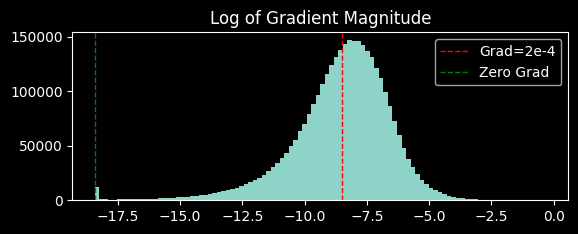

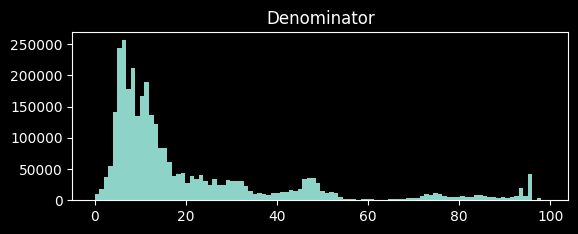

In [10]:
# print("Max Grad: ", gaussians.xyz_gradient_accum.max())
# print("Min Grad: ", gaussians.xyz_gradient_accum.min())
# print("Max denom: ", gaussians.denom.max())
# print("Min denom: ", gaussians.denom.min())

import matplotlib.pyplot as plt

eps = 1e-8
grad_threshold = 0.0002
xyz_grad = gaussians.xyz_gradient_accum.cpu().numpy()
xyz_grad_log = np.log(xyz_grad + eps)
fig = plt.figure()
plt.subplot(2, 1, 1)
plt.hist(xyz_grad_log, bins=100)
plt.axvline(np.log(grad_threshold), color='r', linestyle='dashed', linewidth=1)
plt.axvline(np.log(eps), color='g', linestyle='dashed', linewidth=1)
plt.legend(['Grad=2e-4', 'Zero Grad'])
plt.title('Log of Gradient Magnitude')
plt.show()

denom = gaussians.denom.cpu().numpy()
plt.subplot(2, 1, 2)
plt.hist(denom, bins=100)
plt.title('Denominator')
plt.show()

In [16]:
import plyfile
import numpy as np
from utils.sh_utils import SH2RGB

points = gaussians.get_xyz.detach().cpu().numpy().astype(np.float32)

color = np.zeros([points.shape[0], 3], dtype=np.float32)
color[xyz_grad_log[:, 0] > np.log(grad_threshold), 0] = 255
# color = SH2RGB(gaussians._features_dc[:, 0].detach().cpu().numpy())
# color = (color - color.min()) / (color.max() - color.min()) * 255
points = np.concatenate([points, color], axis=1)
elements = np.empty(points.shape[0], dtype=[('x', 'f4'), ('y', 'f4'), ('z', 'f4'), ('red', 'u1'), ('green', 'u1'), ('blue', 'u1')])
elements[:] = list(map(tuple, points))
el = plyfile.PlyElement.describe(elements, 'vertex')
plyfile.PlyData([el]).write(os.path.join(asset_path, "point_cloud", "iteration_" + str(7000), "point_cloud_grad.ply"))

## 2. View Rendering Results

In [2]:
eval_path = './eval/1st_eval/'
folders = os.listdir(eval_path)

metrics_dict = {}
for folder in folders:
    result_path = os.path.join(eval_path, folder, 'results.json')

    if not os.path.exists(result_path):
        continue
    if folder not in scenes:
        continue
    data = json.load(open(result_path))
    for key in data.keys():
        if key not in metrics_dict:
            metrics_dict[key] = {}
            metrics_dict[key]['name'] = []
        metrics_dict[key]['name'].append(folder)
        for metric_key in data[key].keys():
            if metric_key not in metrics_dict[key]:
                metrics_dict[key][metric_key] = []
            metrics_dict[key][metric_key].append(data[key][metric_key])

# turn metrics_dict to a PrettyTable
table = PrettyTable()
avg_dict = []
for iter in metrics_dict.keys():
    for key in metrics_dict[iter].keys():
        if key == 'name':
            metrics_dict[iter][key].append('AVERAGE')
            table.add_column(iter, metrics_dict[iter][key])
        else:
            col_data = np.array(metrics_dict[iter][key])
            avg = np.mean(col_data)
            col_data = np.append(col_data, avg)
            table.add_column(key, np.round(col_data, decimals=4))
print(table.get_string())

+------------+--------+---------+--------+-----------+--------+---------+--------+
| ours_30000 |  SSIM  |   PSNR  | LPIPS  | ours_7000 |  SSIM  |   PSNR  | LPIPS  |
+------------+--------+---------+--------+-----------+--------+---------+--------+
| drjohnson  | 0.9004 | 29.0834 | 0.2445 | drjohnson | 0.8615 | 27.0283 | 0.3328 |
|  playroom  | 0.9072 | 30.0093 | 0.2433 |  playroom | 0.8979 | 29.5556 | 0.2867 |
|  AVERAGE   | 0.9038 | 29.5463 | 0.2439 |  AVERAGE  | 0.8797 |  28.292 | 0.3097 |
+------------+--------+---------+--------+-----------+--------+---------+--------+


In [3]:
import matplotlib.pyplot as plt

scene = 'train'
# img_path = os.path.join(eval_path, scene, 'test/ours_30000')
# gt_path = os.path.join(img_path, 'gt')
# renders_path = os.path.join(img_path, 'renders')
img_path = os.path.join('output', 'org_ssim_0.5_tandt_train', 'test/ours_30000/renders')
gt_path = os.path.join('output', 'org_ssim_0.5_tandt_train', 'test/ours_30000/gt')
renders_path = os.path.join('output', 'org_tandt_train', '20231018073341/test/ours_30000/renders')

file_names = os.listdir(gt_path)
file_names.sort()

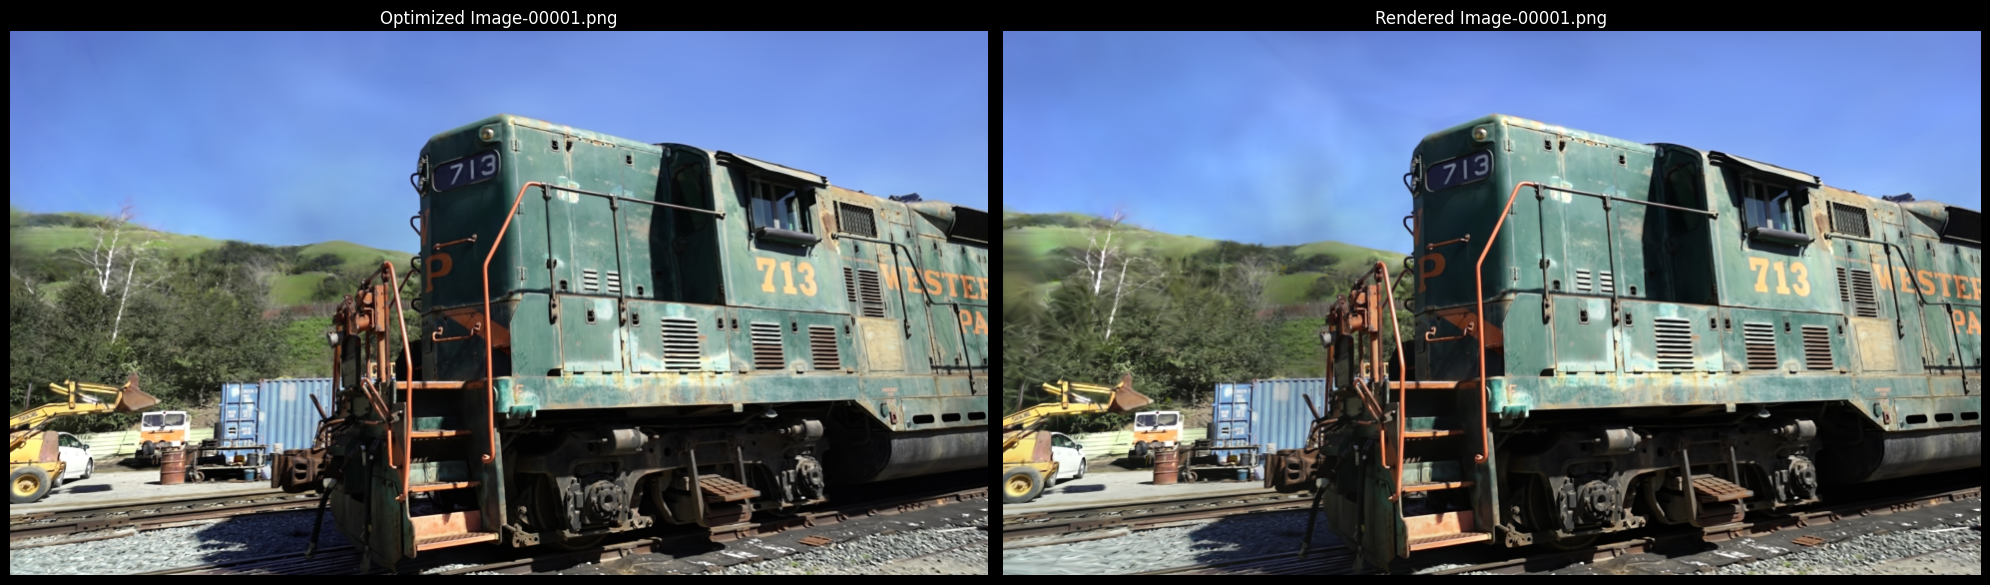

In [6]:
if img_idx is None:
    img_idx = 0
else:
    img_idx = (img_idx + 1) % len(file_names)

plt.figure(figsize=(20, 40))
gt_img = plt.imread(os.path.join(gt_path, file_names[img_idx]))
plt.subplot(1, 2, 1)
plt.imshow(gt_img)
plt.title(f'Ground Truth-{file_names[img_idx]}')
plt.axis('off')
opt_img = plt.imread(os.path.join(img_path, file_names[img_idx]))
plt.subplot(1, 2, 1)
plt.imshow(opt_img)
plt.title(f'Optimized Image-{file_names[img_idx]}')
plt.axis('off')
render_img = plt.imread(os.path.join(renders_path, file_names[img_idx]))
plt.subplot(1, 2, 2)
plt.imshow(render_img)
plt.title(f'Rendered Image-{file_names[img_idx]}')
plt.axis('off')
plt.tight_layout()
plt.show()

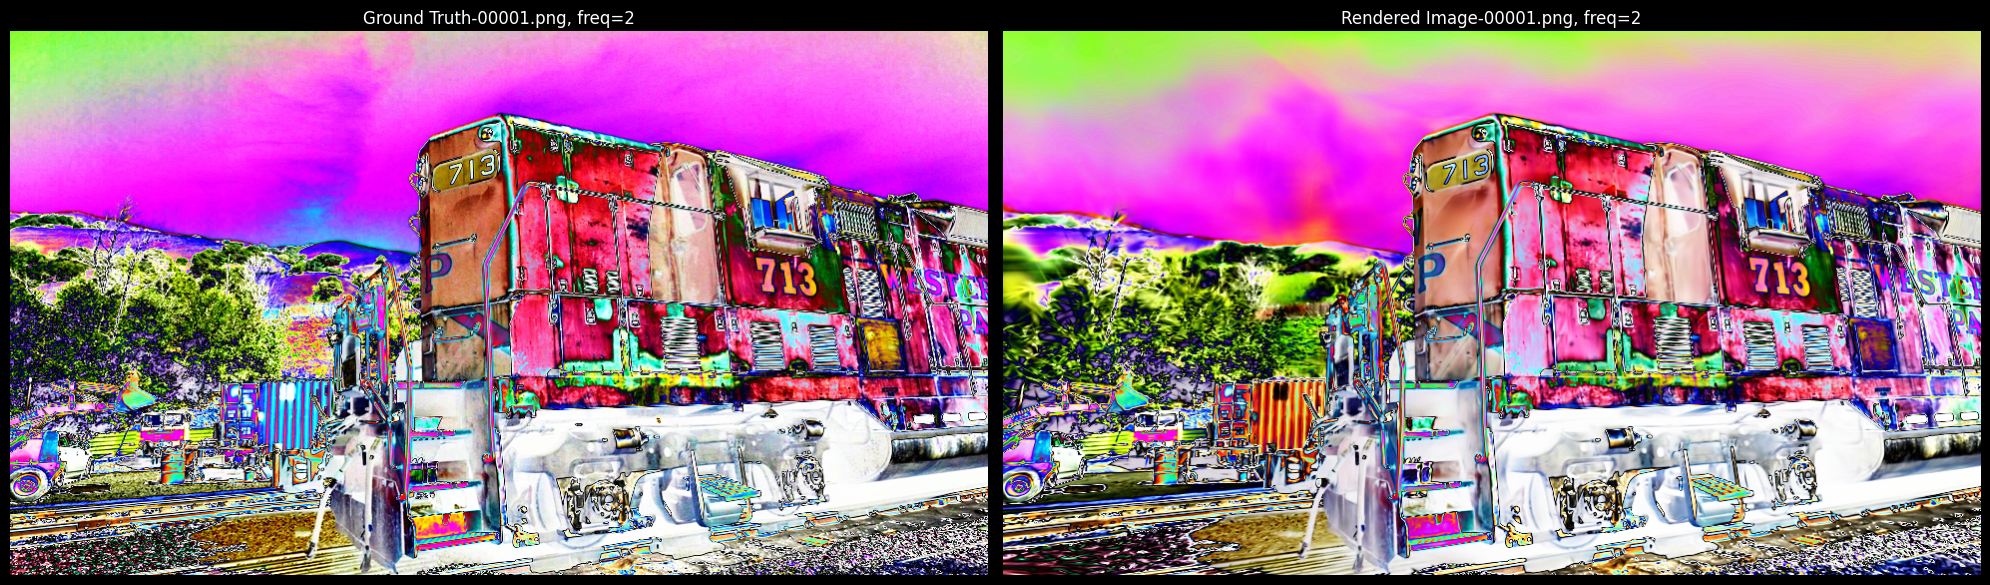

In [7]:
freq = np.power(2, 1)
gt_img_freq = (np.cos(2 * np.pi * freq * gt_img) + 1.0) / 2.0
plt.figure(figsize=(20, 40))
plt.subplot(1, 2, 1)
plt.imshow(gt_img_freq)
plt.title(f'Ground Truth-{file_names[img_idx]}, freq={freq}')
plt.axis('off')
render_img_freq = (np.cos(2 * np.pi * freq * render_img) + 1.0) / 2.0
plt.subplot(1, 2, 2)
plt.imshow(render_img_freq)
plt.title(f'Rendered Image-{file_names[img_idx]}, freq={freq}')
plt.axis('off')
plt.tight_layout()
plt.show()